<a href="https://colab.research.google.com/github/jaowadx30/VisionTransformers/blob/main/VisionTransformers_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install datasets transformers torch

In [28]:
# import CIFAR-10 dataset from HuggingFace
from datasets import load_dataset

dataset_train = load_dataset(
    'cifar10',
    split='train', # training dataset
    # ignore_verifications=True  # set to True if seeing splits Error
)

dataset_train=dataset_train.select(range(7000))

In [29]:
dataset_test = load_dataset(
    'cifar10',
    split='test',
)
dataset_test = dataset_test.select(range(2100))

In [30]:
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(10,
 ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

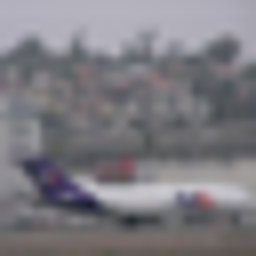

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

In [31]:
from IPython.display import display
display(dataset_train[0]['img'].resize((256, 256)))
dataset_train[0]

In [32]:
from transformers import ViTFeatureExtractor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained( model_name_or_path)

In [33]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [34]:
example = feature_extractor(
    dataset_train[0]['img'],
    return_tensors='pt'
)
example

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [35]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [36]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [37]:
def preprocess(batch):
  inputs = feature_extractor(
      batch['img'],
      return_tensors='pt'
  )
  inputs['label']=batch['label']
  return inputs

In [38]:
prepared_train = dataset_train.with_transform(preprocess)
prepared_test = dataset_test.with_transform(preprocess)

In [39]:
def collate_fn(batch):
  return {
      'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      'labels':torch.tensor([x['label'] for x in batch])
  }

In [40]:
!pip install evaluate
import numpy as np
from evaluate import load

metric = load('accuracy')
def compute_metrics(p):
  return metric.compute(
      predictions=np.argmax(p.predictions,axis=1),
      references = p.label_ids
  )

In [41]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir = "./cifar",
    per_device_train_batch_size = 32,
    evaluation_strategy="steps",
    num_train_epochs = 1,
    save_steps = 100,
    eval_steps = 100,
    logging_steps = 10,
    learning_rate = 2e-4,
    save_total_limit = 2,
    remove_unused_columns = False,
    push_to_hub = False,
    load_best_model_at_end = True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
from transformers import ViTForImageClassification
labels = dataset_train.features['label'].names
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels = len(labels)
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
from transformers import Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    train_dataset = prepared_train,
    eval_dataset = prepared_test,
    tokenizer = feature_extractor
)

<ipython-input-43-b3d79e7799e8>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [44]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train",train_results.metrics)
trainer.save_metrics("train",train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.291200,0.287404,0.949048
200,0.188900,0.183793,0.968571


***** train metrics *****
  epoch                    =         1.0
  total_flos               = 505226497GF
  train_loss               =      0.4599
  train_runtime            =  0:05:02.84
  train_samples_per_second =      23.114
  train_steps_per_second   =       0.723


In [45]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval",metrics)
trainer.save_metrics("eval",metrics)

***** eval metrics *****
  epoch                   =        1.0
  eval_accuracy           =     0.9686
  eval_loss               =     0.1838
  eval_runtime            = 0:00:30.55
  eval_samples_per_second =     68.738
  eval_steps_per_second   =      8.609


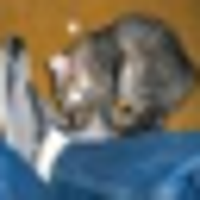

In [46]:
image = dataset_test['img'][0].resize((200,200))
image

In [47]:
actual_label = dataset_test['label'][0]
labels = dataset_test.features['label']
actual_label, labels.names[actual_label]

(3, 'cat')

In [48]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
model_name_or_path = 'LaCarnevali/vit-cifar10'
model_finetuned = ViTForImageClassification.from_pretrained(
    model_name_or_path
)
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(
    model_name_or_path
)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [49]:
inputs = feature_extractor_finetuned(image,return_tensors = "pt")
with torch.no_grad():
  logits = model_finetuned(**inputs).logits

In [50]:
predicted_label = logits.argmax(-1).item()
labels = dataset_test.features['label']
labels.names[predicted_label]

'cat'